<a href="https://colab.research.google.com/github/iankim20/NGS-Research/blob/main/P12_blood_aligned_analys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/vcf data"

/content/drive/My Drive/vcf data


In [ ]:
pip install scikit-allel

ERROR: Operation cancelled by user


In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
 
# import scikit-allel
import allel
# check which version is installed
print(allel.__version__)

1.3.2


In [ ]:
chr_list = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
vcf_files=[]
vcf_files = [f for f in os.listdir('./P12_vcf/') if f.endswith('.vcf')]


In [ ]:
file0 = 'SRR5967951_final.vcf'

In [ ]:
rna0 = allel.read_vcf('./P12_vcf/'+file0)

# rna0['calldata/GT'][:,0:2,:]
genotypes = rna0['calldata/GT'][:,2:4,:]



In [ ]:
# check = []
# for i in range(len(merge_gt)):
#   if not(np.array_equal(merge_gt[i],[-1,-1])):
#     check.append(merge_gt[i]) 

# i = 85

In [ ]:

def merge_variant (genotypes):
  merge_gt = []
  for i in range(len(genotypes)):
    gt = genotypes[i]
    if np.array_equal(gt[0],[-1,-1]) and np.array_equal(gt[1],[-1,-1]):
      merge_gt.append([-1,-1])
    elif not(np.array_equal(gt[0],[-1,-1])) and np.array_equal(gt[1],[-1,-1]):
      merge_gt.append(gt[0])
    elif np.array_equal(gt[0],[-1,-1]) and not(np.array_equal(gt[1],[-1,-1])):
      merge_gt.append(gt[1]) 
    elif not(np.array_equal(gt[0],[-1,-1])) and not(np.array_equal(gt[1],[-1,-1])):
      merge_gt.append([NaN, NaN])
  merge_gt = np.asarray(merge_gt)
  return merge_gt

def merge_vcf (merge_gt, rna_path):
  columns = ['CHROM', 'POS','ID','REF','ALT','QUAL','DP', 'variant_mat','variant_pat']
  rna0 = allel.read_vcf(rna_path)

  rna0_df = pd.DataFrame(columns=columns)
  rna0_df['CHROM'] = rna0['variants/CHROM']
  # rna0_df['FILTER'] = rna0['variants/FILTER_PASS']
  rna0_df['POS'] = rna0['variants/POS']
  rna0_df['ID'] = rna0['variants/ID']
  rna0_df['REF'] = rna0['variants/REF']
  rna0_df['ALT'] = rna0['variants/ALT'][:,0]
  rna0_df['QUAL'] = rna0['variants/QUAL']
  rna0_df['DP'] = allel.read_vcf(rna_path, fields=['DP'])['variants/DP']
  rna0_df['variant_mat'] = merge_gt[:,0]
  rna0_df['variant_pat'] = merge_gt[:,1]
  return rna0_df



# merge_gt=merge_variant(genotypes)

In [ ]:
vcf_df0 = merge_vcf(merge_variant(rna0['calldata/GT'][:,2:4,:]), './P12_vcf/'+file0)

In [ ]:
vcf_df0_nonan = vcf_df0[(vcf_df0['variant_mat'] != -1) & (vcf_df0['variant_pat'] != -1)]
vcf_df0_nonan_chr = vcf_df0_nonan[vcf_df0_nonan['CHROM'].isin(chr_list)]

check = pd.DataFrame(vcf_df0_nonan_chr)

# vcf_df0_nonan_chr.to_csv('SRR5957544.csv')

# sum(merge_gt[:,1] ==2)

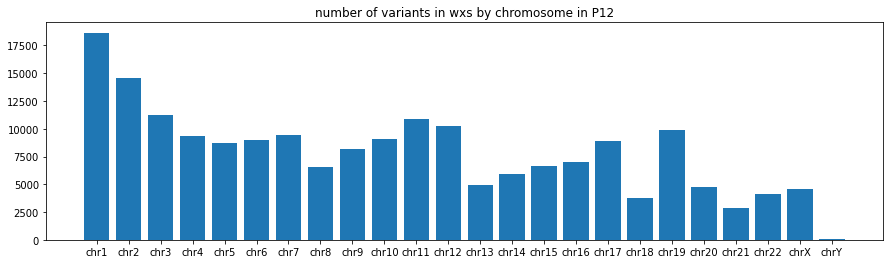

In [ ]:
### make wxs in the same format ###

wxs = allel.read_vcf('SRR5908368_final.vcf')
wxs_df = merge_vcf(merge_variant(wxs['calldata/GT']),'SRR5908368_final.vcf')

wxs_df_nonan = wxs_df[(wxs_df['variant_mat'] != -1) & (wxs_df['variant_pat'] != -1)]
wxs_df_nonan_chr = wxs_df_nonan[wxs_df_nonan['CHROM'].isin(chr_list)]

plt.figure(figsize=(15,4))
plt.bar(chr_list,[len(wxs_df_nonan_chr[wxs_df_nonan_chr['CHROM']==chr_list[i]]) for i in range(24)])
plt.title("number of variants in wxs by chromosome in P12")
plt.show()


In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
len(wxs['calldata/GT'])

In [ ]:
colnames2=['CHROM','POS','variant_mat_rna','variant_pat_rna','variant_mat_wxs','variant_pat_wxs']
overlap0 = pd.DataFrame(columns=colnames2)

In [ ]:
colnames2=['CHROM','POS','variant_mat_rna','variant_pat_rna','variant_mat_wxs','variant_pat_wxs']
overlap0 = pd.DataFrame(columns=colnames2)

for chr in chr_list:
  mini_rna = vcf_df0_nonan_chr[vcf_df0_nonan_chr['CHROM']==chr]
  mini_wxs = wxs_df_nonan_chr[wxs_df_nonan_chr['CHROM']==chr]
  wxs_pos = mini_wxs['POS'].values
  chr_df = pd.DataFrame(columns=colnames2)

  overlap_mini_rna = mini_rna[mini_rna['POS'].isin(wxs_pos)]
  # chrom= overlap0['CHROM'].append(overlap_mini_rna['CHROM'])
  # pos = overlap0['POS'].append(overlap_mini_rna['POS'])
  # mat_rna = overlap0['variant_mat_rna'].append(overlap_mini_rna['variant_mat'])
  # pat_rna = overlap0['variant_pat_rna'].append(overlap_mini_rna['variant_pat'])
  chr_df['CHROM']= overlap_mini_rna['CHROM']
  chr_df['POS']= overlap_mini_rna['POS']
  chr_df['variant_mat_rna']= overlap_mini_rna['variant_mat']
  chr_df['variant_pat_rna']= overlap_mini_rna['variant_pat']

  overlap_mini_wxs = mini_wxs[mini_wxs['POS'].isin(overlap_mini_rna['POS'].values)]
  list1 = overlap_mini_wxs['variant_mat']
  list2 = overlap_mini_wxs['variant_pat']
  chr_df['variant_mat_wxs'] =list1.tolist()
  chr_df['variant_pat_wxs'] = list2.tolist()
  # mat_wxs = overlap0['variant_mat_wxs'].append(overlap_mini_wxs['variant_mat'])
  # pat_wxs = int(overlap0['variant_pat_wxs'].append(overlap_mini_wxs['variant_pat']))
  # overlap0['CHROM']=chrom
  # overlap0['POS']=pos
  # overlap0['variant_mat_rna']=mat_rna
  # overlap0['variant_pat_rna']=pat_rna
  # overlap0['variant_mat_wxs']=mat_wxs
  # overlap0['variant_pat_wxs']=pat_wxs
  print(list1.tolist, list2, chr)

  overlap0 = pd.concat([overlap0,chr_df])







In [ ]:
colnames3 = ['CHROM','ADO']
ADO_cell0 = pd.DataFrame(columns=colnames3)

In [ ]:
# chr='chr1'

wxs_hetero = overlap0[overlap0['variant_mat_wxs']!=overlap0['variant_pat_wxs']]
chr_overlap_wxs_hetero_list = list(dict.fromkeys(wxs_hetero['CHROM']))

for chr in chr_overlap_wxs_hetero_list:
  mini = wxs_hetero[wxs_hetero['CHROM']==chr]
  mini_df = pd.DataFrame(columns=colnames3)

  num_homo_rna = sum (mini['variant_mat_rna'] == mini['variant_pat_rna'])
  ado = num_homo_rna / len(mini)
  mini_df['CHROM']=[chr]
  mini_df['ADO']=[ado]

  ADO_cell0 = pd.concat([ADO_cell0,mini_df])





In [ ]:
colnames4 = ['CHROM','POS']
ADropout_cell0 = pd.DataFrame(columns=colnames4)

In [ ]:
# chr='chr1'

wxs_hetero = overlap0[overlap0['variant_mat_wxs']!=overlap0['variant_pat_wxs']]
wxs_hetero_rna_homo = wxs_hetero[wxs_hetero['variant_mat_rna']==wxs_hetero['variant_pat_rna']]




In [ ]:
plt.hist(vcf_df0_nonan_chr['QUAL'], bins=range(min(data), max(data)))

data = vcf_df0_nonan_chr['QUAL']
plt.hist(data, bins=[0, 500,1000,1500,2000,2500,3000,3500,4000])

NameError: ignored

In [ ]:
def make_ado_per_cell(file_path):
  rna0 = allel.read_vcf(file_path)
  vcf_df0 = merge_vcf(merge_variant(rna0['calldata/GT'][:,2:4,:]), file_path)

  vcf_df0_nonan = vcf_df0[(vcf_df0['variant_mat'] != -1) & (vcf_df0['variant_pat'] != -1)]
  vcf_df0_nonan_chr = vcf_df0_nonan[vcf_df0_nonan['CHROM'].isin(chr_list)]

  colnames2=['CHROM','POS','variant_mat_rna','variant_pat_rna','variant_mat_wxs','variant_pat_wxs']
  overlap0 = pd.DataFrame(columns=colnames2)

  num_sc_homo = []
  num_wxs_hetero = []
  pos = []

  for chr in chr_list:
    mini_rna = vcf_df0_nonan_chr[vcf_df0_nonan_chr['CHROM']==chr]
    mini_wxs = wxs_df_nonan_chr[wxs_df_nonan_chr['CHROM']==chr]
    wxs_pos = mini_wxs['POS'].values
    chr_df = pd.DataFrame(columns=colnames2)

    overlap_mini_rna = mini_rna[mini_rna['POS'].isin(wxs_pos)]
    chr_df['CHROM']= overlap_mini_rna['CHROM']
    chr_df['POS']= overlap_mini_rna['POS']
    chr_df['variant_mat_rna']= overlap_mini_rna['variant_mat']
    chr_df['variant_pat_rna']= overlap_mini_rna['variant_pat']

    overlap_mini_wxs = mini_wxs[mini_wxs['POS'].isin(overlap_mini_rna['POS'].values)]
    list1 = overlap_mini_wxs['variant_mat']
    list2 = overlap_mini_wxs['variant_pat']
    chr_df['variant_mat_wxs'] =list1.tolist()
    chr_df['variant_pat_wxs'] = list2.tolist()

    overlap0 = pd.concat([overlap0,chr_df])

  colnames3 = ['CHROM','ADO']
  ADO_cell0 = pd.DataFrame(columns=colnames3) 
  wxs_hetero = overlap0[overlap0['variant_mat_wxs']!=overlap0['variant_pat_wxs']]
  chr_overlap_wxs_hetero_list = list(dict.fromkeys(wxs_hetero['CHROM']))

  for chr in chr_overlap_wxs_hetero_list:
    mini = wxs_hetero[wxs_hetero['CHROM']==chr]
    mini_df = pd.DataFrame(columns=colnames3)

    num_homo_rna = sum (mini['variant_mat_rna'] == mini['variant_pat_rna'])
    ado = num_homo_rna / len(mini)
    pos = mini['POS'].values
    mini_df['CHROM']=[chr]
    mini_df['POS']=[pos]
    mini_df['ADO']=[ado]

    ADO_cell0 = pd.concat([ADO_cell0,mini_df])
    
    num_sc_homo.append(num_homo_rna)
    num_wxs_hetero.append(len(mini))

  return ADO_cell0, num_sc_homo, num_wxs_hetero



In [ ]:
i=85

In [ ]:
j=5

In [ ]:
final_df = pd.DataFrame(0, index=chr_list, columns=vcf_files)

for i in range(len(vcf_files)):
  file_path = './P14_vcf/'+vcf_files[i]

  ADO_cell0, num_sc_homo, num_wxs_hetero = make_ado_per_cell(file_path)

  count_homo=0
  count_wxs_hetero=0

  for j in range(len(ADO_cell0)):
    chromosome = ADO_cell0.iloc[j,0]
    final_df.loc[chromosome,vcf_files[i]] = str(ADO_cell0.iloc[j,1].round(2)) + " ("+ str(num_sc_homo[j]) + "/" + str(num_wxs_hetero[j]) + ")"

    count_homo += num_sc_homo[j]
    count_wxs_hetero += num_wxs_hetero[j]
  
  print("final_df filled until ", i+1 ,"th cell, total ", count_homo, " out of ", count_wxs_hetero)



In [ ]:
final_df.to_csv('P11_aligned_1214_check.csv')

In [ ]:
final_df_numbers = pd.DataFrame(0, index=chr_list, columns=vcf_files)

for i in range(len(vcf_files)):
  file_path = './P12_vcf/'+vcf_files[i]

  ADO_cell0, num_sc_homo, num_wxs_hetero = make_ado_per_cell(file_path)

  count_homo=0
  count_wxs_hetero=0

  for j in range(len(ADO_cell0)):
    chromosome = ADO_cell0.iloc[j,0]
    final_df_numbers.loc[chromosome,vcf_files[i]] = str(ADO_cell0.iloc[j,1].round(2))

    count_homo += num_sc_homo[j]
    count_wxs_hetero += num_wxs_hetero[j]
  
  print("final_df filled until ", i+1 ,"th cell, total ", count_homo, " out of ", count_wxs_hetero)

In [ ]:
# final_df_numbers.to_csv('overlap_P12_blood_1219_numbers.csv')

cellnames = []
for i in range(len(vcf_files)):
  cellnames.append("cell"+str(i+1))

plot_df = final_df_numbers

In [ ]:
plot_df.columns = cellnames

In [ ]:
plot_df.replace(0, np.nan, inplace=True)

In [ ]:
plot_df.T.barplot(figsize=(30,8), fontsize=15)

In [ ]:
plot_df.boxplot(column=[1,2])

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


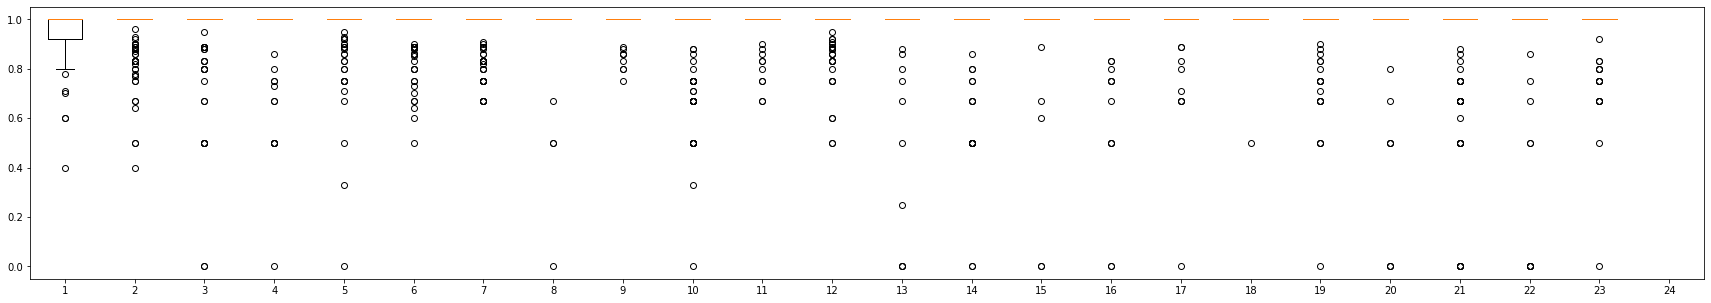

In [ ]:
# # fake up some data
# spread = np.random.rand(50) * 100
# center = np.ones(25) * 50
# flier_high = np.random.rand(10) * 100 + 100
# flier_low = np.random.rand(10) * -100
# data = np.concatenate((spread, center, flier_high, flier_low), 0)

# data = np.column_stack((data, data * 2., data + 20.))

# # Add a NaN
# data[30, 0] = np.NaN
# data[20, 1] = np.NaN

data = plot_df.to_numpy(dtype=np.float64)

# Filter data using np.isnan
mask = ~np.isnan(data)
filtered_data = [d[m] for d, m in zip(data, mask)]
# filtered_data = [d[m] for d, m in zip(data.T, mask.T)]


# basic plot
plt.figure(figsize=(30,5))
plt.boxplot(filtered_data)
plt.show()

In [ ]:
plot_df.loc['chr10',:].values

array([0.67, 1.  , 0.89, 1.  , 1.  , 1.  , 1.  , 0.75, 1.  , 0.67, 1.  ,
       0.67,  nan, 1.  , 0.67, 1.  ,  nan, 1.  , 0.75, 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 0.75,  nan, 1.  , 1.  , 0.67,  nan, 1.  ,
       1.  ,  nan, 0.5 , 1.  , 0.5 , 0.88, 0.67,  nan, 0.8 , 0.92, 1.  ,
       1.  , 0.86, 0.67, 0.5 , 0.5 , 1.  , 1.  , 0.57,  nan, 0.5 , 1.  ,
       1.  , 0.8 ,  nan, 0.5 , 1.  , 1.  , 0.8 , 1.  , 0.5 , 0.67,  nan,
       0.67, 1.  , 0.8 , 1.  , 1.  , 1.  , 1.  , 0.8 ,  nan, 1.  , 0.5 ,
        nan, 0.75, 0.8 , 0.5 , 1.  , 0.75, 1.  , 0.5 , 0.67, 1.  , 1.  ,
       1.  , 0.67, 0.83])

In [ ]:


fig, ax = plt.subplots(figsize=(25,10))
for n, col in enumerate(final_df_numbers.columns):
    ax.boxplot(final_df_numbers[col], positions=[n+1])

ax.set_xticks(range(10))
ax.set_xticklabels(range(10))
plt.show()


,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,cell9,cell10,cell11,cell12,cell13,cell14,cell15,cell16,cell17,cell18,cell19,cell20,cell21,cell22,cell23,cell24,cell25,cell26,cell27,cell28,cell29,cell30,cell31,cell32,cell33,cell34,cell35,cell36,cell37,cell38,cell39,cell40,cell41,cell42,cell43,cell44,cell45,cell46,cell47,cell48,cell49,cell50
chr1,0.94,0.97,1.0,1.0,0.96,0.95,0.95,0.89,1.0,0.97,0.89,0.95,0.94,0.96,0.96,0.95,0.95,1.0,0.95,0.96,0.96,0.96,0.94,0.96,0.97,0.95,1.0,0.96,0.94,0.97,0.96,0.93,0.94,1.0,0.98,0.95,0.97,0.92,0.93,0.95,0.95,1.0,0.96,0.97,1.0,0.9,1.0,0.94,0.95,1.0
chr2,0.96,0.83,0.93,0.91,0.89,0.86,0.91,0.74,0.88,0.83,1.0,0.93,0.84,0.65,0.95,1.0,0.91,0.89,0.79,0.9,0.92,0.88,0.91,1.0,0.95,0.89,1.0,0.86,0.87,0.79,0.95,0.83,0.8,0.76,1.0,0.94,0.96,0.91,0.87,0.96,0.86,0.94,0.94,0.89,0.86,0.81,0.77,0.93,0.8,0.92
chr3,0.97,0.89,0.97,0.9,0.97,0.93,0.95,1.0,0.86,1.0,0.94,0.96,0.94,1.0,0.9,1.0,1.0,0.92,0.94,1.0,1.0,0.97,0.96,0.96,0.98,0.97,1.0,0.96,0.93,0.96,1.0,0.97,1.0,0.9,1.0,0.94,0.95,0.91,0.85,1.0,0.91,0.95,1.0,0.96,0.93,0.88,0.93,0.8,0.9,0.96
chr4,1.0,1.0,1.0,1.0,1.0,0.88,1.0,1.0,1.0,1.0,0.75,1.0,1.0,0.96,1.0,0.88,1.0,1.0,1.0,0.86,1.0,0.91,1.0,1.0,1.0,1.0,0.86,1.0,1.0,1.0,1.0,1.0,0.86,0.93,0.92,0.95,1.0,1.0,0.95,1.0,0.93,1.0,0.92,1.0,1.0,0.88,1.0,1.0,1.0,0.94
chr5,0.88,0.89,1.0,1.0,0.89,1.0,1.0,1.0,1.0,1.0,0.86,0.92,0.86,1.0,1.0,1.0,1.0,1.0,0.67,0.94,1.0,1.0,0.94,1.0,1.0,0.86,1.0,1.0,1.0,0.94,1.0,1.0,1.0,1.0,0.92,0.94,1.0,1.0,0.96,1.0,1.0,1.0,1.0,1.0,0.9,1.0,1.0,1.0,1.0,1.0
chr6,0.73,0.73,0.92,0.83,0.75,0.64,0.81,0.93,0.79,0.9,0.89,0.71,0.67,0.73,0.94,0.79,0.82,1.0,0.92,0.71,0.75,0.79,0.75,0.91,0.91,0.82,0.75,0.53,0.81,0.69,0.69,1.0,0.75,0.85,0.8,0.89,0.88,0.77,0.84,0.88,0.69,0.8,0.9,0.81,0.83,0.83,0.88,0.79,0.8,0.85
chr7,0.92,1.0,0.88,1.0,0.93,1.0,0.91,0.92,0.88,0.78,0.91,0.94,0.9,0.79,0.67,0.89,0.77,0.89,0.88,0.93,0.86,0.83,1.0,0.93,0.89,1.0,1.0,0.8,0.94,0.95,1.0,0.88,0.8,0.77,0.88,0.62,0.95,0.82,0.96,0.94,0.87,0.92,0.93,1.0,0.91,0.88,1.0,0.95,0.76,0.75
chr8,1.0,1.0,1.0,0.67,0.89,1.0,0.89,0.91,0.89,1.0,1.0,0.83,0.82,0.91,0.94,1.0,1.0,0.88,0.85,0.88,0.94,0.94,0.85,0.8,1.0,0.91,1.0,0.9,0.88,1.0,0.94,0.92,0.92,0.93,0.88,0.88,0.91,0.91,0.95,0.95,1.0,1.0,1.0,0.88,0.81,0.94,0.92,0.92,0.89,1.0
chr9,0.85,0.72,0.88,1.0,0.93,0.89,0.94,0.84,0.85,1.0,0.92,0.78,0.86,0.83,0.79,0.88,0.87,0.92,1.0,0.94,0.9,0.94,0.96,1.0,0.84,0.78,0.86,0.95,0.73,0.86,0.93,0.9,0.56,1.0,0.88,0.83,0.89,0.83,0.69,0.95,0.78,0.79,0.83,1.0,0.75,1.0,0.9,1.0,0.88,0.71
chr10,0.91,1.0,0.85,1.0,0.95,0.67,0.91,1.0,1.0,1.0,0.67,0.88,0.83,0.94,0.94,0.86,0.75,1.0,1.0,1.0,1.0,0.67,0.75,1.0,1.0,0.86,0.8,1.0,0.89,0.71,0.9,0.81,0.77,0.62,0.89,0.84,0.93,0.91,0.75,0.92,0.89,0.55,0.9,0.7,0.67,0.5,0.83,0.94,0.86,1.0


In [ ]:
final_df_pos = pd.DataFrame([], index=chr_list, columns=vcf_files)
final_df_numbers = pd.DataFrame(0, index=chr_list, columns=vcf_files)


for i in range(len(vcf_files)):
  file_path = './P12_vcf/'+vcf_files[i]

  ADO_cell0, num_sc_homo, num_wxs_hetero = make_ado_per_cell(file_path)

  count_homo=0
  count_wxs_hetero=0

  for j in range(len(ADO_cell0)):
    chromosome = ADO_cell0.iloc[j,0]
    final_df_pos.loc[chromosome,vcf_files[i]] = ADO_cell0.iloc[j,2].tolist()

    final_df_numbers.loc[chromosome,vcf_files[i]] = str(ADO_cell0.iloc[j,1].round(2))

    count_homo += num_sc_homo[j]
    count_wxs_hetero += num_wxs_hetero[j]
  
  print("final_df filled until ", i+1 ,"th cell, total ", num_sc_homo, " out of ", num_wxs_hetero)

final_df filled until  1 th cell, total  [12, 6, 1, 1, 5, 4, 1, 3, 4, 1, 2, 1, 2, 4, 6]  out of  [13, 6, 1, 1, 5, 4, 1, 3, 4, 1, 2, 1, 2, 4, 6]
final_df filled until  2 th cell, total  [7, 5, 1, 5, 1, 5, 6, 4, 1, 1, 3, 1, 3, 1, 3, 1, 1, 5]  out of  [7, 5, 1, 5, 1, 5, 6, 4, 1, 1, 3, 1, 3, 1, 3, 1, 1, 5]
final_df filled until  3 th cell, total  [5, 6, 4, 1, 8, 7, 7, 2, 4, 5, 4, 7, 1, 3, 6, 1, 5, 3]  out of  [6, 7, 5, 1, 8, 7, 7, 2, 4, 5, 4, 8, 2, 3, 6, 1, 5, 3]
final_df filled until  4 th cell, total  [4, 3, 6, 1, 7, 4, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2]  out of  [4, 3, 6, 1, 7, 4, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 2]
final_df filled until  5 th cell, total  [3, 3, 3, 4, 4, 4, 1, 4, 3, 4, 8, 3, 2, 8, 3, 3, 2, 1, 2]  out of  [3, 3, 3, 4, 4, 4, 1, 4, 3, 4, 8, 3, 2, 9, 3, 3, 2, 1, 2]
final_df filled until  6 th cell, total  [1, 6, 2, 4, 4, 2, 1, 6, 1, 2, 1, 3, 1, 2, 2, 3]  out of  [1, 6, 2, 4, 4, 2, 1, 6, 1, 2, 1, 3, 1, 2, 2, 3]
final_df filled until  7 th cell, total  [7, 8, 3, 3, 3, 3, 7, 1, 9,

In [ ]:
imprinted_genes = pd.read_csv('gene_result.csv')

genes = imprinted_genes[['GeneID','Symbol','chromosome','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession']]

In [ ]:
overlap = pd.DataFrame([], index=range(len(genes)), columns=vcf_files)
genes = pd.concat([genes,overlap],axis=1)

In [ ]:
import math

for i in range(len(genes)):
  start = genes.iloc[i,3]
  end = genes.iloc[i,4]
  chr = "chr"+str(genes.iloc[i,2])
  for num in range(len(vcf_files)):
    file = vcf_files[num]
    pos = final_df_pos.loc[chr, file]
    check = float("NaN")
    if type(pos) == float:
      check = check
    elif type(pos) == list:
      evaluate = 0
      for each in pos:
        if (each >= start) & (each <= end):
          evaluate += 1
        else:
          evaluate = evaluate
      if evaluate > 0:
        check = 1
      elif evaluate == 0:
        check = 0
      else:
        print("somethings wrong with evaluate")
    else:
      print("type of pos is weird")
    
    genes.iloc[i,num+5] = check
  


In [ ]:
genes.to_csv('overlap_P12_blood_1219.csv')
final_df_numbers.to_csv('overlap_P12_blood_1219_numbers.csv')


In [ ]:
chr = 'chr1'

In [ ]:
genome = allel.read_vcf('wxs.vcf')
genome_gt = allel.GenotypeArray(genome['calldata/GT'])

chr_index = []
for chr_ind in range(len(genome_pos)):
  if genome['variants/CHROM'][chr_ind] in chr_list:
    chr_index.append(chr_ind)

genome_pos = genome['variants/POS'][chr_index]  #chr 1 to Y

genome_location = []
for i in range(len(genome_pos)):
  genome_location.append(genome['variants/CHROM'][chr_index][i]+'-'+str(genome_pos[i]))


<GenotypeArray shape=(100422, 2, 2) dtype=int8>
./. ./.
./. ./.
0/1 ./.
...
./. ./.
./. ./.
./. ./.

In [ ]:
rna0_df[:20]

,CHROM,POS,ID,REF,ALT,QUAL,DP,variant
0,chr1,19608399,.,C,A,65.279999,6,"[-1, -1]"
1,chr1,19608436,.,T,C,63.279999,6,"[-1, -1]"
2,chr1,27649605,.,G,A,152.029999,4,"[-1, -1]"
3,chr1,27649611,.,C,T,152.029999,4,"[-1, -1]"
4,chr1,36090653,.,G,A,21.799999,7,"[0, 1]"
5,chr1,37958181,.,G,C,123.900002,13,"[1, 1]"
6,chr1,39560904,.,A,ACCTTCGCG,43.790001,3,"[-1, -1]"
7,chr1,39560906,.,A,C,52.820000,3,"[-1, -1]"
8,chr1,43384802,.,A,G,40.740002,2,"[-1, -1]"
9,chr1,50629298,.,T,C,383.769989,26,"[1, 1]"


In [ ]:
test = allel.read_vcf(vcf_files[0])
# test_df = allel.vcf_to_dataframe(vcf_files[0])

test_pos_whole = test['variants/POS']

chr_index_sc = []
for chr_ind in range(len(test_pos_whole)):
  if test['variants/CHROM'][chr_ind] in chr_list:
    chr_index_sc.append(chr_ind)                         ##only in chr_list

In [ ]:
test_gt = allel.GenotypeArray(test['calldata/GT'][chr_index_sc])   # in chr 1 to Y
 
check_homo = np.asarray(test_gt.is_hom())     # in chr 1 to Y

homo_ind = []
for i in range(len(check_homo)):
  if (check_homo[i][0]==True or check_homo[i][1]==True):
    homo_ind.append(i)

In [ ]:
test_pos_chr = test_pos_whole[chr_index_sc]  #chr1 to Y
test_pos_homo = test_pos_chr[homo_ind]       #pos of homozygotes in chr 1 to Y

test_df = []
for i in range(len(test_pos_homo)):
  test_df.append(test['variants/CHROM'][chr_index_sc][homo_ind][i]+'-'+str(test_pos_homo[i]))


# data = {'chr': test['variants/CHROM'][chr_index_sc], 'pos': test['variants/POS'][chr_index_sc]


column_names = ["location", "genome"]
overlap=pd.DataFrame(columns=column_names)


    


SyntaxError: ignored

In [ ]:
column_names = ["location", "genome_snp", "genome_indel"]
overlap=pd.DataFrame(columns=column_names)

for chr in chr_list:
  chr_in_genome = np.where(genome['variants/CHROM'][chr_index]==chr)
  chr_in_sc = np.where(test['variants/CHROM'][chr_index_sc][homo_ind]==chr)
  genome_gt = allel.GenotypeArray(genome['calldata/GT'][chr_in_genome])
  check_hetero = np.asarray(genome_gt.is_het())
  for i in test_pos_homo[chr_in_sc]:
    if i in genome_pos[chr_in_genome]:
      df2 = pd.DataFrame({"location":[chr+'-'+str(i)], "genome":[check_hetero.loc[i][0]]}) 
      overlap.append(df2)
                               

In [ ]:
for chr in chr_list:
  chr_in_genome = np.where(genome['variants/CHROM'][chr_index]==chr)
  chr_in_sc = np.where(test['variants/CHROM'][chr_index_sc][homo_ind]==chr)
  genome_gt = allel.GenotypeArray(genome['calldata/GT'][chr_in_genome])
  check_hetero = np.asarray(genome_gt.is_het())
  for i in test_pos_homo[chr_in_sc]:
    if i in genome_pos[chr_in_genome]:
      df2 = pd.DataFrame({"location":[chr+'-'+str(i)], "genome":[check_hetero[i][0]]}) 
      overlap.append(df2)
                               

In [ ]:
for file in vcf_files:
    

In [ ]:
f = open('deletions_filter1.csv', 'r')

In [ ]:
scRNA = []

for files in vcf_files:
  



SyntaxError: ignored